# Clasificación de Flores / CNN Transfer Learning

# 1 Carga de Imágenes

In [ ]:
# Importamos las librerías a utilizar

import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# Descargamos el set de datos

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [ ]:
# Contamos el número de imágenes

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


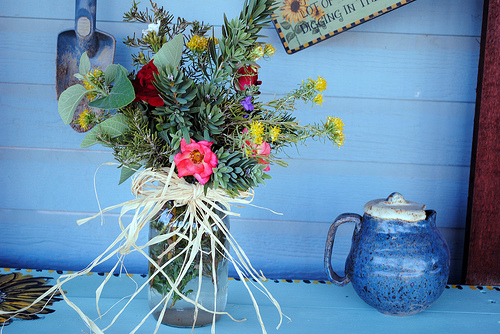

In [ ]:
# Mostramos un ejemplo

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# 2 Procesamiento de Imágenes

In [ ]:
# Definimos algunos parámetros

#epocas = 25
#altura, longitud= 224, 224
#batch = 32
#pasos_epoca = 32 #entrenamiento / batch = 2939 / 32 = datagen_entrenamiento.image_shape[0] // batch = 91
#pasos_validacion = 23 #validacion / batch = 731 / 32 = datagen_validacion.image_shape[0] // batch = 23
#filtrosConv1 = 32
#filtrosConv2 = 64
#tamano_filtro1 = (3,3)
#tamano_filtro2 = (2,2)
#tamano_pool = (2,2)
#clases = 5
#lr = 0.0005

In [ ]:
# Aumentamos los datos con ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [ ]:
# Generamos los sets de entrenamiento y validación

altura, longitud= 224, 224
batch = 32

datagen_entrenamiento = datagen.flow_from_directory(
    data_dir,
    target_size=(altura, longitud),
    batch_size=batch,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

datagen_validacion = datagen.flow_from_directory(
    data_dir,
    target_size=(altura, longitud),
    batch_size=batch,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
# Validamos el tamaño de los datos

datagen_entrenamiento.image_shape

(224, 224, 3)

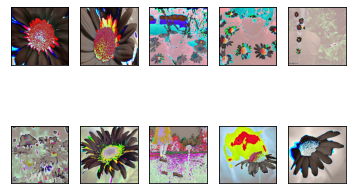

In [ ]:
# Mostramos algunas imágenes de entrenamiento

import matplotlib.pyplot as plt

for imagen, etiqueta in datagen_validacion:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i].astype("uint8"))
  break
plt.show()

# 3 Carga de la Red

In [ ]:
# Cargamos el modelo de red MobileNet

from keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

# 4 Modelado de la Red

In [ ]:
# Cargamos el modelo base

base_model = MobileNet(input_shape=(altura, longitud, 3),
                       include_top=False,
                       pooling='max',
                       weights='imagenet'
)

base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
# Congelamos las capas de entrenamiento

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

# 5 Finetunning

In [ ]:
# Añadimos capas a la red

from keras.layers import Dropout, Dense, Flatten
from keras.engine.training import Model

clases = 5

x = Flatten(name='flatten')(base_model.output)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
out = Dense(clases, activation='softmax', name='output')(x)

custom_model = Model(base_model.input, out)
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
from keras.saving.saving_utils import optimizers
# Compilamos el modelo

lr = 0.0005

custom_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Callbacks EarlyStopping

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
)

In [ ]:
# Ajustamos el modelo

from keras import callbacks

epocas = 50
pasos_epoca = 32 #entrenamiento / batch
pasos_validacion = 23 #validacion / batch

historial = custom_model.fit(
    datagen_entrenamiento,
    steps_per_epoch=pasos_epoca,
    epochs=epocas,
    validation_data=datagen_validacion,
    validation_steps=pasos_validacion,
    callbacks=[early_stop]
)

Epoch 1/30
32/32 [==============================] - 62s 2s/step - loss: 2.6761 - accuracy: 0.2891 - val_loss: 1.4418 - val_accuracy: 0.3844
Epoch 2/30
32/32 [==============================] - 60s 2s/step - loss: 1.4850 - accuracy: 0.3398 - val_loss: 1.3541 - val_accuracy: 0.4514
Epoch 3/30
32/32 [==============================] - 59s 2s/step - loss: 1.3658 - accuracy: 0.4141 - val_loss: 1.2046 - val_accuracy: 0.5007
Epoch 4/30
32/32 [==============================] - 60s 2s/step - loss: 1.2774 - accuracy: 0.4570 - val_loss: 1.1314 - val_accuracy: 0.5499
Epoch 5/30
32/32 [==============================] - 60s 2s/step - loss: 1.2489 - accuracy: 0.4678 - val_loss: 1.1383 - val_accuracy: 0.5691
Epoch 6/30
32/32 [==============================] - 61s 2s/step - loss: 1.2267 - accuracy: 0.4779 - val_loss: 1.1724 - val_accuracy: 0.5185
Epoch 7/30
32/32 [==============================] - 60s 2s/step - loss: 1.2114 - accuracy: 0.4824 - val_loss: 1.0526 - val_accuracy: 0.5910
Epoch 8/30
32/32 [==

# 6 Evaluación del Modelo

In [ ]:
# Obtenemos las métricas del modelo

score = custom_model.evaluate(datagen_validacion, steps=pasos_validacion)
print("Loss Validacion: {}\nAccuracy Validacion: {}".format(score[0], score[1]))

23/23 [==============================] - 26s 1s/step - loss: 0.7268 - accuracy: 0.7360
Loss Validacion: 0.7267887592315674
Accuracy Validacion: 0.7359781265258789


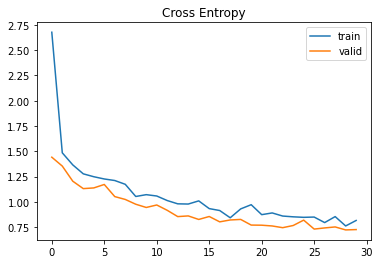

In [ ]:
# Graficamos la evolución de la pérdida en el modelo

plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

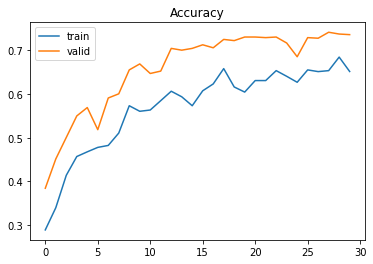

In [ ]:
# Graficamos la evolución del accuracy en el modelo

plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()